# Data analysis project

Written by Julien Samuel, Mayuxiang Chen and Jolan Kerrien

In [114]:
import numpy as np
from scipy import stats
from math import sqrt
from scipy.stats import chi2_contingency
import pandas as pd
#Ploting librairies:
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

## 1) Graphical Representation of all the variables with respect to the target + Computing the correlation

Functions that will help us through our analysis

In [115]:
# Importation of the data 
df = pd.read_csv('energy_data.csv')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,North,0.0,type1,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,South,0.0,type1,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,Est,0.0,type1,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,West,0.0,type1,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,North,0.0,type1,20.84,28.28


Correspondance of the variable
- X1 Relative Compactness
- X2 Surface Area
- X3 Wall Area
- X4 Roof Area
- X5 Overall Height
- X6 Orientation
- X7 Glazing Area
- X8 Glazing Area Distribution

In [116]:
def identify_missing(data): 
    ''' Identify the features missing values NaN
    Return list of features with the number of missing values 
    input = dataframe and print dataframe '''
    missing = data.isnull().sum()
    missing_result = pd.DataFrame(missing).reset_index().rename(columns = {'index' : 'features', 0 :'missing_nbr'})
    missing_result['missing_fraction']=(missing_result.missing_nbr/data.shape[0])*100
    print(missing_result)
    
def information_about_data(data): 
    '''numeric features : get the min and the max
       categorical features get the nbr of classes
       input = a dataframe and prints statistics of columns of this dataframe'''
    print(" ")
    print("Numerical features")
    for col in data.columns : 
        if data[col].dtype != 'object' :
            print('The feature "%s" have a minimum value of %s and a maximum value of %s' % (col,data[col].min(), data[col].max()))

    print(" ")
    print("Categorical features")
    for col in data.columns : 
        if data[col].dtype == 'object' :
            print('The feature "%s" have %s unique values which are %s' % (col,len(data[col].unique()),data[col].unique()))
            
def Plot(df,Y_value):
    for i in [1,2,3,4,5,7]:
        plt.plot(df[f'X{i}'],df[f'Y{Y_value}'],'.',label = f'Y{Y_value} (X{i})')
        plt.legend()
        plt.show()
    

In [117]:
identify_missing(df)

  features  missing_nbr  missing_fraction
0       X1            0               0.0
1       X2            0               0.0
2       X3            0               0.0
3       X4            0               0.0
4       X5            0               0.0
5       X6            0               0.0
6       X7            0               0.0
7       X8            0               0.0
8       Y1            0               0.0
9       Y2            0               0.0


There is no missing numbers in our data, so no need to think about a way of replaced them

In [118]:
information_about_data(df)

 
Numerical features
The feature "X1" have a minimum value of 0.62 and a maximum value of 0.98
The feature "X2" have a minimum value of 514.5 and a maximum value of 808.5
The feature "X3" have a minimum value of 245.0 and a maximum value of 416.5
The feature "X4" have a minimum value of 110.25 and a maximum value of 220.5
The feature "X5" have a minimum value of 3.5 and a maximum value of 7.0
The feature "X7" have a minimum value of 0.0 and a maximum value of 0.4
The feature "Y1" have a minimum value of 6.01 and a maximum value of 43.1
The feature "Y2" have a minimum value of 10.9 and a maximum value of 48.03
 
Categorical features
The feature "X6" have 4 unique values which are ['North' 'South' 'Est' 'West']
The feature "X8" have 6 unique values which are ['type1' 'type2' 'type3' 'type4' 'type5' 'type6']


### Tracer des $X_i$ en fonction de $Y_1$ puis $Y_2$

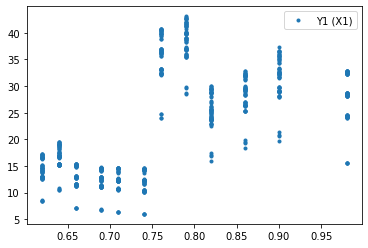

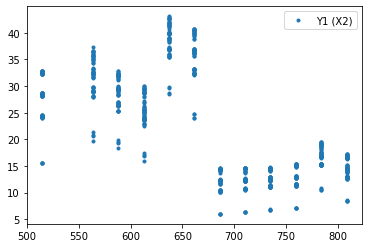

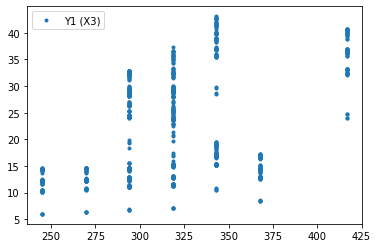

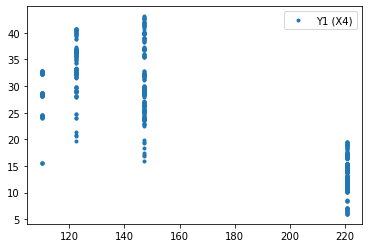

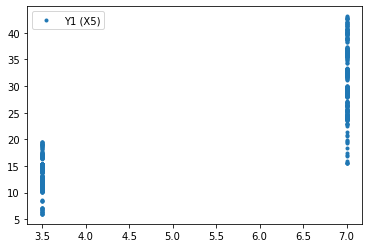

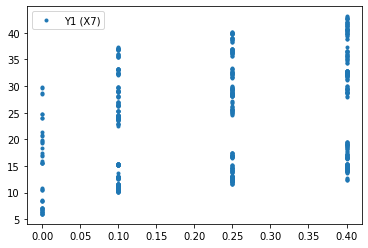

In [119]:
Plot(df,1)

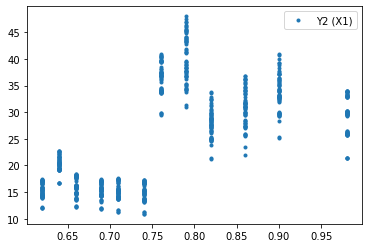

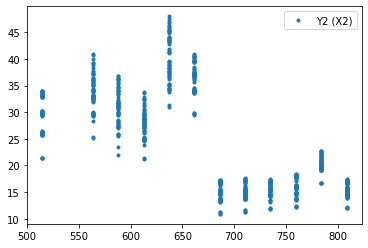

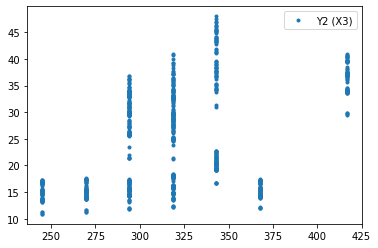

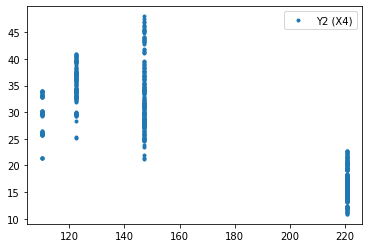

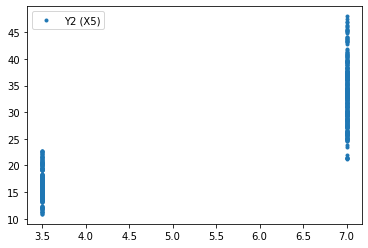

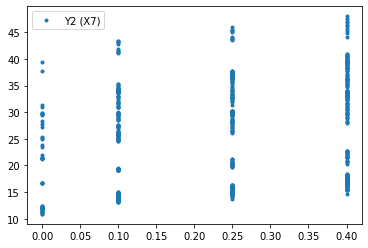

In [120]:
Plot(df,2)

## Transformation of the categorical variables

The orientation X6 can be replace by Yes ou No
The glazing area distribution X8 can be replace by 1,2,3,4,5,6

In [121]:
def plot_figure(axx,w,h,df):
    ''' input = dataframe df , name of column of interest axx , width and height of the graph
        we will rotate the ticks of the x axis and ha=right means that 
        If we imagine a rectangular box around the rotated label, 
        which side of the rectangle do we want to be aligned with the tickpoint '''
    plt.figure(figsize=(w,h))
    sns.countplot(df[axx])
    plt.xticks(rotation = 30, ha='right')
    plt.title(axx + ' distribution')
    plt.show()

#plot distribution between a categorical value and a numerical value in an histogram via predefined function
def plot_figure_num(x_var,groupby_var,w,h, nbr_bins,x_min, x_max,step_x,df,colors):
    '''input : name of numerical variable , name of categorical variable ,width,height, 
               nbr_bins,x_min numeric, x_max numeric,step_x to show ,dataframe'''
    #x_var = 'hours-per-week'
    #groupby_var = 'income'
    df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
    vals = [df[x_var].values.tolist() for i, df in df_agg]
    plt.figure(figsize=(w,h))
    n, bins, patches = plt.hist(vals, nbr_bins, stacked=True, color=colors[:len(vals)], edgecolor = 'black') 
    plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
    plt.xlabel(x_var)
    plt.ylabel("count")
    plt.xticks(np.arange(x_min, x_max, step=step_x))
    plt.title(x_var + ' distribution in function of ' + groupby_var)
    plt.show()

C:\Users\jolan\miniconda3\envs\py385\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


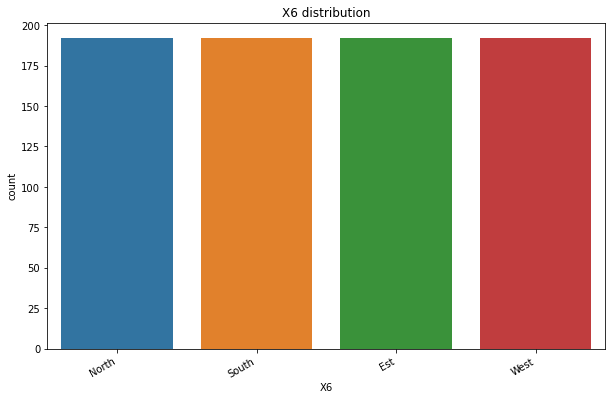

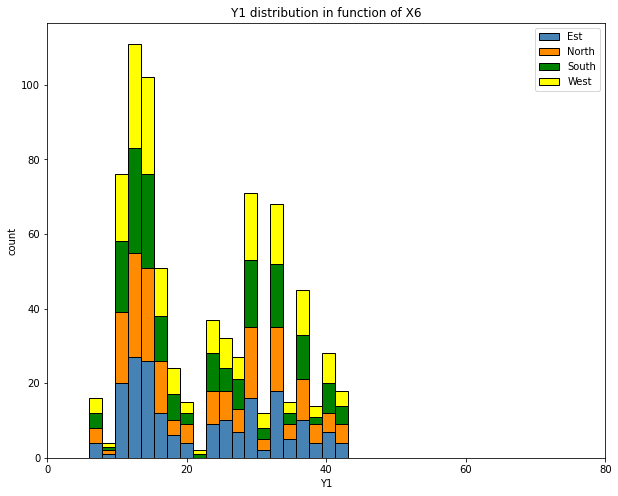

In [122]:
plot_figure('X6',10,6,df)  
plot_figure_num('Y1','X6',10,8, 20,0, 100,20,df,['steelblue','darkorange','green','yellow'])

C:\Users\jolan\miniconda3\envs\py385\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


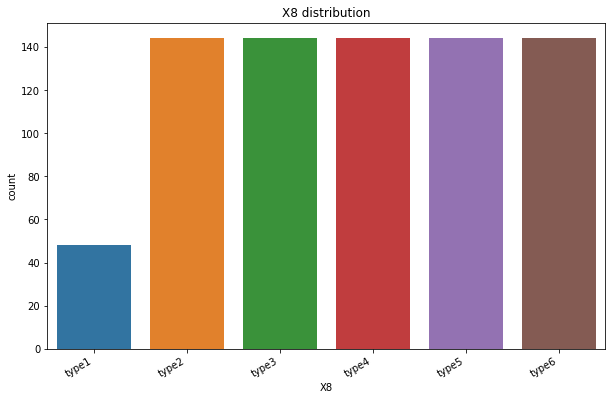

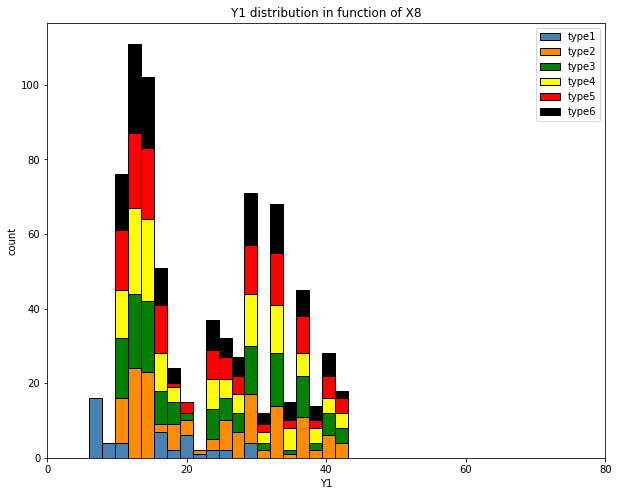

In [123]:
plot_figure('X8',10,6,df)
plot_figure_num('Y1','X8',10,8, 20,0, 100,20,df,['steelblue','darkorange','green','yellow','red','black'])

## Normalize variables